## Import necessary libraries

In [11]:
import os

import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, \
                          Flatten, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.resnet50 import ResNet50
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

## Define hyperparameters

In [12]:
BATCH_SIZE = 32
EPOCHS = 100
IMG_HEIGHT = 48
IMG_WIDTH = 48
NUM_OUTPUTS = 5
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.3
L2_WEIGHT_DECAY = 1e-6

## Load the dataset

In [13]:
! rm -rf ./dataset
! git clone https://github.com/drumpt/facial_expression_data

Cloning into 'facial_expression_data'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 28886 (delta 29), reused 86 (delta 20), pack-reused 28783
Receiving objects: 100% (28886/28886), 44.97 MiB | 11.46 MiB/s, done.
Resolving deltas: 100% (31/31), done.


The dataset has the following directory structure:

<pre>
<b>dataset</b>
|__ <b>train</b>
    |______ <b>angry</b>: [0.jpg, 1.jpg, 10.jpg, ...]
    |______ <b>happy</b>: [100.jpg, 10000.jpg, 10001.jpg, ...]
    |______ <b>neutral</b>: [1000.jpg, 10003.jpg, 10014.jpg, ...]
    |______ <b>sad</b>: [10006.jpg, 10008.jpg, 1001.jpg, ...]
    |______ <b>surprise</b>: [10007.jpg, 10009.jpg, 10011.jpg, ...]
|__ <b>validation</b>
    |______ <b>angry</b>: [10052.jpg, 10065.jpg, 10079.jpg, ....]
    |______ <b>happy</b>: [10019.jpg, 10023.jpg, 10074.jpg, ...]
    |______ <b>neutral</b>: [10033.jpg, 10048.jpg, 10068.jpg, ...]
    |______ <b>sad</b>: [10004.jpg, 1003.jpg, 10031.jpg, ...]
    |______ <b>surprise</b>: [10056.jpg, 10097.jpg, 10162.jpg, ...]
</pre>

In [14]:
train_dir = os.path.join("./dataset/train", "train")
validation_dir = os.path.join("./dataset/validation", "validation")

train_angry_dir = os.path.join(train_dir, "angry")
train_happy_dir = os.path.join(train_dir, "happy")
train_neutral_dir = os.path.join(train_dir, "neutral")
train_sad_dir = os.path.join(train_dir, "sad")
train_surprise_dir = os.path.join(train_dir, "surprise")

validation_angry_dir = os.path.join(validation_dir, "angry")
validation_happy_dir = os.path.join(validation_dir, "happy")
validation_neutral_dir = os.path.join(validation_dir, "neutral")
validation_sad_dir = os.path.join(validation_dir, "sad")
validation_surprise_dir = os.path.join(validation_dir, "surprise")

num_angry_tr = len(os.listdir(train_angry_dir))
num_happy_tr = len(os.listdir(train_happy_dir))
num_neutral_tr = len(os.listdir(train_neutral_dir))
num_sad_tr = len(os.listdir(train_sad_dir))
num_surprise_tr = len(os.listdir(train_surprise_dir))

num_angry_val = len(os.listdir(validation_angry_dir))
num_happy_val = len(os.listdir(validation_happy_dir))
num_neutral_val = len(os.listdir(validation_neutral_dir))
num_sad_val = len(os.listdir(validation_sad_dir))
num_surprise_val = len(os.listdir(validation_surprise_dir))

total_train = num_angry_tr + num_happy_tr + num_neutral_tr + num_sad_tr + num_surprise_tr
total_val = num_angry_val + num_happy_val + num_neutral_val + num_sad_val + num_surprise_val

# debug
print('total # of training set :', total_train)
print('total # of train_angry :', num_angry_tr)
print('total # of train_happy :', num_happy_tr)
print('total # of train_neutral :', num_neutral_tr)
print('total # of train_sad :', num_sad_tr)
print('total # of train_surprise :', num_surprise_tr, "\n")

print('total # of validation set :', total_val)
print('total # of validation_angry :', num_angry_val)
print('total # of validation_happy :', num_happy_val)
print('total # of validation_neutral :', num_neutral_val)
print('total # of validation_sad :', num_sad_val)
print('total # of validation_surprise :', num_surprise_val)

total # of training set : 23622
total # of train_angry : 3487
total # of train_happy : 7156
total # of train_neutral : 4850
total # of train_sad : 4922
total # of train_surprise : 3207 

total # of validation set : 5754
total # of validation_angry : 835
total # of validation_happy : 1824
total # of validation_neutral : 1163
total # of validation_sad : 1138
total # of validation_surprise : 794


## Preprocess the dataset

In [15]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [16]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = train_dir,
    color_mode = 'grayscale',
    shuffle = True,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical'
)
val_data_gen = validation_image_generator.flow_from_directory(
    batch_size = BATCH_SIZE,
    directory = validation_dir,
    color_mode = 'grayscale',
    shuffle = False,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical'
  )

Found 23616 images belonging to 5 classes.
Found 5754 images belonging to 5 classes.


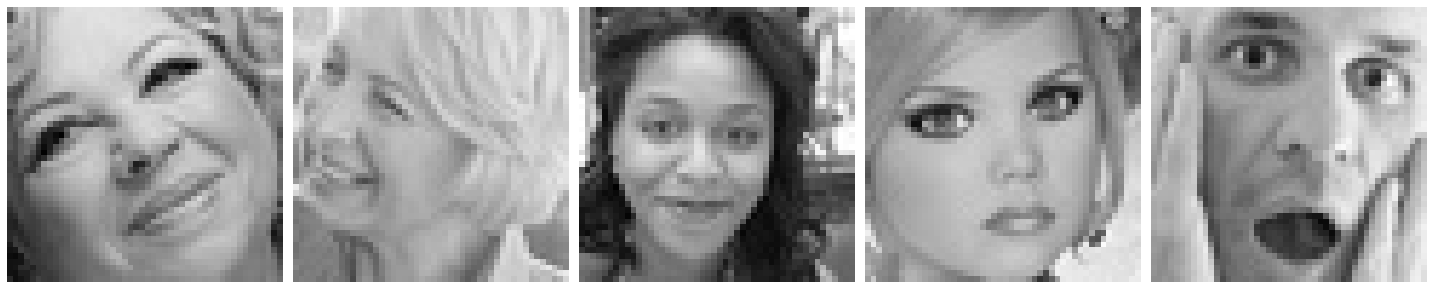

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

## Define model

In [18]:
def simple_cnn():
  model = Sequential()
  input_shape = (IMG_HEIGHT, IMG_WIDTH, 1)
  model.add(Conv2D(128, (5, 5), input_shape=input_shape, activation='relu', padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(Conv2D(128, (5, 5), activation='relu', padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(Conv2D(128, (5, 5),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Conv2D(128, (3, 3),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(Conv2D(128, (3, 3),activation='relu',padding='same', kernel_regularizer = regularizers.l2(L2_WEIGHT_DECAY)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(DROPOUT_RATE))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(DROPOUT_RATE))
  model.add(Dense(NUM_OUTPUTS, activation="softmax"))
  model.add(Activation('softmax'))
  return model

def resnet_fine_tuning():
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(NUM_OUTPUTS, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=x)
  return model

model = simple_cnn()
# model = resnet_fine_tuning()

optimizer = Adam(lr = LEARNING_RATE, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-7)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer = optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 128)       9728      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 48, 48, 128)       409728    
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)       409728    
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 128)      

## Train model

In [19]:
# from google.colab import drive
# drive.mount("/content/gdrive", force_remount = False)

# def get_drive_path():
#   path = F"/content/gdrive/MyDrive/Colab Notebooks/weights/"
#   path += "weights_{epoch:02d}_{accuracy:.4f}_{val_accuracy:.4f}.h5"
#   return path

def get_local_path():
  path = os.path.join("weights/", "weights_{epoch:02d}_{accuracy:.4f}_{val_accuracy:.4f}.h5")
  return path

# path = get_drive_path()
path = get_local_path()
save_model_callback = ModelCheckpoint(filepath = path)

history = model.fit(
    train_data_gen,
    steps_per_epoch = total_train // BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    validation_steps = total_val // BATCH_SIZE,
    callbacks = [save_model_callback]
)

Epoch 1/100
738/738 [==============================] - 15s 21ms/step - loss: 1.5652 - accuracy: 0.3092 - val_loss: 1.5437 - val_accuracy: 0.3375
Epoch 2/100
738/738 [==============================] - 15s 20ms/step - loss: 1.4937 - accuracy: 0.3893 - val_loss: 1.4607 - val_accuracy: 0.4256
Epoch 3/100
738/738 [==============================] - 15s 20ms/step - loss: 1.4267 - accuracy: 0.4625 - val_loss: 1.5477 - val_accuracy: 0.3294
Epoch 4/100
738/738 [==============================] - 15s 20ms/step - loss: 1.3910 - accuracy: 0.4992 - val_loss: 1.4421 - val_accuracy: 0.4539
Epoch 5/100
738/738 [==============================] - 15s 20ms/step - loss: 1.3601 - accuracy: 0.5338 - val_loss: 1.3605 - val_accuracy: 0.5318
Epoch 6/100
738/738 [==============================] - 15s 20ms/step - loss: 1.3289 - accuracy: 0.5673 - val_loss: 1.5201 - val_accuracy: 0.3689
Epoch 7/100
738/738 [==============================] - 15s 20ms/step - loss: 1.3023 - accuracy: 0.5961 - val_loss: 1.2812 - val_ac

738/738 [==============================] - 15s 21ms/step - loss: 1.0739 - accuracy: 0.8319 - val_loss: 1.2015 - val_accuracy: 0.7030
Epoch 58/100
738/738 [==============================] - 15s 21ms/step - loss: 1.0741 - accuracy: 0.8315 - val_loss: 1.1810 - val_accuracy: 0.7243
Epoch 59/100
738/738 [==============================] - 15s 21ms/step - loss: 1.0715 - accuracy: 0.8346 - val_loss: 1.1716 - val_accuracy: 0.7327
Epoch 60/100
738/738 [==============================] - 15s 21ms/step - loss: 1.0706 - accuracy: 0.8351 - val_loss: 1.1844 - val_accuracy: 0.7203
Epoch 61/100
738/738 [==============================] - 15s 21ms/step - loss: 1.0678 - accuracy: 0.8380 - val_loss: 1.1802 - val_accuracy: 0.7236
Epoch 62/100
738/738 [==============================] - 15s 20ms/step - loss: 1.0712 - accuracy: 0.8338 - val_loss: 1.1816 - val_accuracy: 0.7233
Epoch 63/100
738/738 [==============================] - 15s 21ms/step - loss: 1.0690 - accuracy: 0.8377 - val_loss: 1.1801 - val_accuracy

## Plot training result

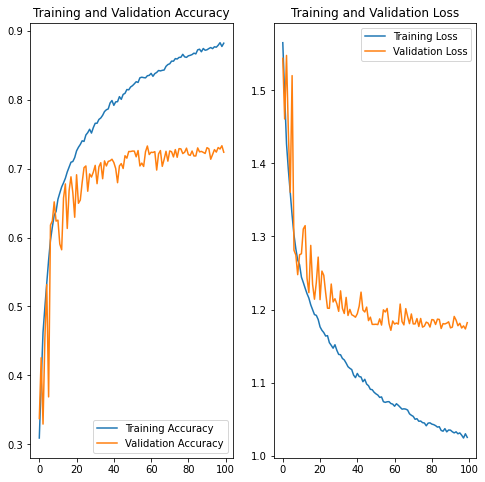

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()